In [1]:
import pandas as pd
# re: مكتبة التعبيرات النمطية (Regular Expressions) لمعالجة النصوص.
import re
# nltk: (Natural Language Toolkit) مكتبة قوية لمعالجة اللغات الطبيعية.
import nltk
# stopwords: من nltk.corpus، تحتوي على قائمة بكلمات التوقف الشائعة في لغات مختلفة.
from nltk.corpus import stopwords
# ISRIStemmer: من nltk.stem، أداة لتجذير الكلمات العربية (إرجاع الكلمة إلى جذرها).
from nltk.stem import ISRIStemmer
# ArabicReshaper: لمساعدة في عرض النصوص العربية بشكل صحيح (تعديل شكل الحروف).
from arabic_reshaper import ArabicReshaper
# get_display: من bidi.algorithm، لمساعدة في عرض النصوص ثنائية الاتجاه (مثل العربية) بشكل صحيح.
from bidi.algorithm import get_display
from sklearn.feature_extraction.text import TfidfVectorizer
# train_test_split: من scikit-learn.model_selection، لتقسيم البيانات إلى مجموعات تدريب واختبار.
from sklearn.model_selection import train_test_split
# LogisticRegression: من scikit-learn.linear_model، خوارزمية تصنيف شائعة وفعالة.
from sklearn.linear_model import LogisticRegression
# accuracy_score, classification_report, confusion_matrix: من scikit-learn.metrics، لتقييم أداء النموذج.
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# matplotlib.pyplot: مكتبة لرسم المخططات البيانية (مثل مصفوفة الارتباك).
import matplotlib.pyplot as plt
# seaborn: مكتبة لإنشاء رسوم بيانية إحصائية جذابة وجميلة.
import seaborn as sns

In [2]:
file_path =r'C:\Users\fasy\Desktop\sudanese_sentiment_data.xlsx'
try:
    df = pd.read_excel(file_path)
    # إعادة تسمية الأعمدة لتناسب الكود (افترض أن العمود A هو النص والعمود B هو التصنيف)
    df.columns = ['text', 'sentiment']
    print("تم تحميل البيانات بنجاح.")
    print("أول 5 صفوف من البيانات:")
    print(df.head())
    print("\nتوزيع التصنيفات:")
    print(df['sentiment'].value_counts())
except FileNotFoundError:
    print(f"خطأ: ملف '{file_path}' غير موجود. يرجى التأكد من وجود الملف في نفس مجلد الكود.")
    exit() # إيقاف التنفيذ إذا لم يتم العثور على الملف
if len(df) < 10: # رقم تعسفي، يمكن تعديله
    print("\nتحذير: عدد الصفوف في البيانات قليل جدًا. قد لا يكون أداء النموذج جيدًا.")


تم تحميل البيانات بنجاح.
أول 5 صفوف من البيانات:
                                              text  sentiment
0          التعليق ده كلو حكمه و فهم عميق للموضوع           1
1        ياخ الزول ده كلامو كلو ساكت ما عندو معنى           0
2         رأي موفق جدا وموزون و بوضح الصوره كامله           1
3             ده كلام بتاع فارغين ما فيه أي فايدة           0
4  تحليل واقعي ومنطقي للمشكلة ربنا يكتر من امثالك           1

توزيع التصنيفات:
0    1050
1    1037
Name: sentiment, dtype: int64


In [3]:
# --- القسم 2: معالجة النصوص (التنظيف والتجذير) ---

print("\n--- 2. معالجة النصوص ---")

# تحميل كلمات التوقف (Stop Words) للغة العربية من NLTK.
# كلمات التوقف هي الكلمات الشائعة التي لا تضيف معنى كبيراً للمشاعر (مثل 'من', 'إلى', 'هو').
import nltk # استيراد مكتبة NLTK
nltk.download('stopwords') # تنزيل قائمة كلمات التوقف العربية إذا لم تكن موجودة.

# تحويل قائمة كلمات التوقف إلى مجموعة (set) لسرعة البحث.
from nltk.corpus import stopwords # استيراد وحدة stopwords
arabic_stopwords = set(stopwords.words('arabic')) # إنشاء مجموعة من كلمات التوقف العربية.
# تهيئة كائن التجذير (Stemmer) للغة العربية.
from nltk.stem import ISRIStemmer # استيراد وحدة ISRIStemmer
stemmer = ISRIStemmer() # إنشاء كائن لتجذير الكلمات العربية.

# تعريف دالة لمعالجة النصوص العربية.
def preprocess_arabic_text(text):
    # التحقق مما إذا كان المدخل نصاً، لتجنب الأخطاء إذا كانت هناك قيم غير نصية.
    if not isinstance(text, str):
        return "" # إرجاع نص فارغ إذا لم يكن المدخل نصاً.
    
    # إزالة الأرقام من النص.
    import re # استيراد مكتبة re (التعبيرات النمطية)
    text = re.sub(r'[0-9]+', '', text) # استبدال أي سلسلة من الأرقام بنص فارغ.
    # إزالة علامات الترقيم والرموز الخاصة. [\w\s] تعني أي حرف أو مسافة.
    text = re.sub(r'[^\w\s]', '', text) # استبدال أي شيء ليس حرفًا أو مسافة بنص فارغ.
    
    # إزالة المسافات الزائدة والمتعددة واستبدالها بمسافة واحدة، ثم إزالة المسافات من الأطراف.
    text = re.sub(r'\s+', ' ', text).strip() # استبدال أي سلسلة من المسافات بمسافة واحدة وإزالة المسافات الزائدة من البداية والنهاية.
    
    # تقسيم النص إلى قائمة من الكلمات.
    words = text.split() # تقسيم النص بناءً على المسافات.
    
    # معالجة كل كلمة: إزالة كلمات التوقف وتجذير الكلمات.
    processed_words = [] # إنشاء قائمة فارغة لتخزين الكلمات المعالجة.
    for word in words: # المرور على كل كلمة في النص.
        if word not in arabic_stopwords: # إذا لم تكن الكلمة من كلمات التوقف.
            processed_words.append(stemmer.stem(word)) # إضافة جذر الكلمة إلى القائمة.
    
    # إعادة تجميع الكلمات المعالجة في نص واحد مفصول بمسافات.
    processed_text = ' '.join(processed_words) # ضم الكلمات المعالجة بمسافة بينها.
    
    # معالجة النص العربي للعرض الصحيح في البيئات التي قد لا تدعم الاتجاه من اليمين لليسار.
    # هذا الجزء لا يؤثر على عملية بناء النموذج ولكنه لتحسين عرض النص.
    from arabic_reshaper import ArabicReshaper # استيراد وحدة ArabicReshaper
    reshaped_text = ArabicReshaper().reshape(processed_text) # إعادة تشكيل الحروف العربية.
    from bidi.algorithm import get_display # استيراد وحدة get_display
    display_text = get_display(reshaped_text) # ترتيب النص ثنائي الاتجاه.
    
    return display_text # إرجاع النص المعالج.

# تطبيق دالة المعالجة على كل نص في عمود 'text' وإنشاء عمود جديد 'cleaned_text'.
df['cleaned_text'] = df['text'].apply(preprocess_arabic_text) # تطبيق الدالة على كل صف في عمود 'text'.

print("أول 5 صفوف بعد المعالجة (النص الأصلي مقابل النص المعالج):")
print(df[['text', 'cleaned_text', 'sentiment']].head()) # عرض أول 5 صفوف من البيانات بعد المعالجة.


--- 2. معالجة النصوص ---


[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


أول 5 صفوف بعد المعالجة (النص الأصلي مقابل النص المعالج):
                                              text  \
0          التعليق ده كلو حكمه و فهم عميق للموضوع    
1        ياخ الزول ده كلامو كلو ساكت ما عندو معنى    
2         رأي موفق جدا وموزون و بوضح الصوره كامله    
3             ده كلام بتاع فارغين ما فيه أي فايدة    
4  تحليل واقعي ومنطقي للمشكلة ربنا يكتر من امثالك    

                       cleaned_text  sentiment  
0        ﻊﺿﻭ ﻖﻤﻋ ﻢﻬﻓ ﻢﻜﺣ ﻮﻠﻛ ﻩﺩ ﻖﻠﻋ          1  
1  ﻰﻨﻋ ﻭﺪﻨﻋ ﺖﻜﺳ ﻮﻠﻛ ﻮﻤﻠﻛ ﻩﺩ ﻝﻭﺯ ﺥﺎﻳ          0  
2       ﻞﻤﻛ ﺭﻮﺻ ﺢﺿﻭ ﺰﻣﻭ ﺍﺪﺟ ﻖﻓﻭ ﻱﺃﺭ          1  
3                ﺪﻴﻓ ﻍﺮﻓ ﻊﺘﺑ ﻢﻠﻛ ﻩﺩ          0  
4       ﻞﺜﻣ ﺮﺘﻛ ﻦﺑﺭ ﻞﻜﺷ ﻖﻄﻧ ﻊﻗﻭ ﻞﻠﺣ          1  


In [4]:
# --- القسم 3: تحويل النصوص إلى ميزات رقمية (TF-IDF) ---

print("\n--- 3. تحويل النصوص إلى ميزات رقمية ---")

# تحديد الميزات (X) وهي النصوص المعالجة، والهدف (y) وهي التصنيفات.
X = df['cleaned_text'] # عمود النصوص المعالجة.
y = df['sentiment'] # عمود التصنيفات (0 أو 1).

# تقسيم البيانات إلى مجموعات تدريب واختبار.
# X_train, y_train: بيانات التدريب التي سيتعلم منها النموذج.
# X_test, y_test: بيانات الاختبار التي سيتم استخدامها لتقييم أداء النموذج.
# test_size=0.2: 20% من البيانات ستُستخدم للاختبار، و 80% للتدريب.
# random_state=42: يضمن أن التقسيم سيكون متطابقاً في كل مرة تشغل فيها الكود.
# stratify=y: يضمن أن تكون نسبة الفئات (0 و 1) متساوية في مجموعتي التدريب والاختبار.
from sklearn.model_selection import train_test_split # استيراد وحدة train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # تقسيم البيانات.

# تهيئة كائن TF-IDF Vectorizer.
# TF-IDF هي طريقة لوزن الكلمات بناءً على تكرارها في وثيقة ما ومدى ندرتها في جميع الوثائق.
# max_features=5000: سيتم استخدام 5000 كلمة/عبارة فقط (الأكثر شيوعاً) كميزات.
# ngram_range=(1,2): سيتم النظر في الكلمات المفردة (uni-grams) وعبارات من كلمتين (bi-grams) كميزات.
from sklearn.feature_extraction.text import TfidfVectorizer # استيراد وحدة TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2)) # إنشاء كائن TF-IDF.

# تدريب الـ TF-IDF Vectorizer على بيانات التدريب فقط، ثم تحويل النصوص إلى مصفوفة TF-IDF.
# fit_transform يتعلم المفردات من X_train ثم يحول X_train.
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train) # تدريب وتحويل بيانات التدريب.

# تحويل بيانات الاختبار باستخدام الـ TF-IDF Vectorizer الذي تم تدريبه بالفعل.
# مهم: نستخدم transform فقط هنا، وليس fit_transform، لضمان استخدام نفس المفردات التي تعلمها من بيانات التدريب.
X_test_tfidf = tfidf_vectorizer.transform(X_test) # تحويل بيانات الاختبار.

print(f"شكل بيانات التدريب بعد TF-IDF (عدد النصوص، عدد الميزات): {X_train_tfidf.shape}") # عرض شكل بيانات التدريب.
print(f"شكل بيانات الاختبار بعد TF-IDF (عدد النصوص، عدد الميزات): {X_test_tfidf.shape}") # عرض شكل بيانات الاختبار.


--- 3. تحويل النصوص إلى ميزات رقمية ---
شكل بيانات التدريب بعد TF-IDF (عدد النصوص، عدد الميزات): (1669, 5000)
شكل بيانات الاختبار بعد TF-IDF (عدد النصوص، عدد الميزات): (418, 5000)



--- 4. بناء وتدريب النموذج وتقييمه ---
تم تدريب النموذج بنجاح.

دقة النموذج (Accuracy): 0.8158

تقرير التصنيف (Classification Report):
              precision    recall  f1-score   support

           0       0.83      0.80      0.81       210
           1       0.80      0.84      0.82       208

    accuracy                           0.82       418
   macro avg       0.82      0.82      0.82       418
weighted avg       0.82      0.82      0.82       418



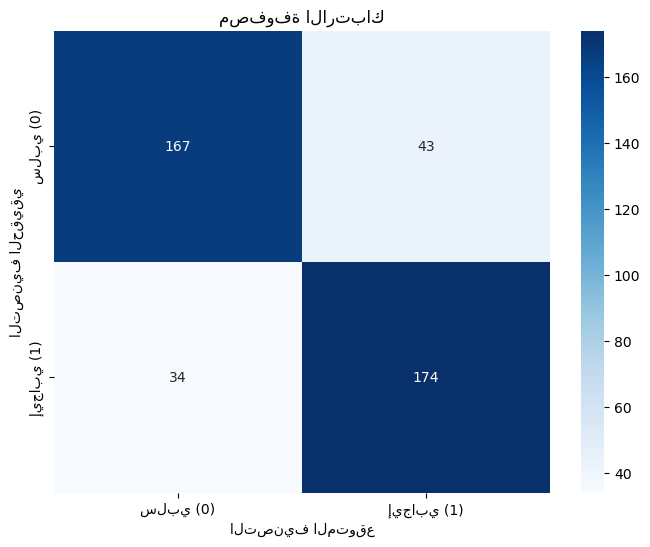

In [5]:
# --- القسم 4: بناء وتدريب النموذج وتقييمه ---

print("\n--- 4. بناء وتدريب النموذج وتقييمه ---")

# تهيئة نموذج الانحدار اللوجستي (Logistic Regression).
# solver='liblinear': خوارزمية تحسين مناسبة للبيانات الصغيرة والمتوسطة الحجم.
# random_state=42: لضمان الحصول على نفس النتائج في كل مرة يتم فيها تشغيل الكود.
from sklearn.linear_model import LogisticRegression # استيراد وحدة LogisticRegression
model = LogisticRegression(solver='liblinear', random_state=42) # إنشاء نموذج الانحدار اللوجستي.

# تدريب النموذج على بيانات التدريب TF-IDF وتصنيفاتها.
model.fit(X_train_tfidf, y_train) # تدريب النموذج.
print("تم تدريب النموذج بنجاح.")

# استخدام النموذج المدرب للتنبؤ بتصنيفات المشاعر على بيانات الاختبار.
y_pred = model.predict(X_test_tfidf) # التنبؤ بالتصنيفات.

# تقييم أداء النموذج.

# 1. الدقة (Accuracy): النسبة المئوية للتنبؤات الصحيحة.
from sklearn.metrics import accuracy_score # استيراد وحدة accuracy_score
accuracy = accuracy_score(y_test, y_pred) # حساب الدقة.
print(f"\nدقة النموذج (Accuracy): {accuracy:.4f}") # عرض الدقة.

# 2. تقرير التصنيف (Classification Report):
# يوفر مقاييس مفصلة لكل فئة (سلبي 0، إيجابي 1):
#   - Precision: من كل التنبؤات التي قال النموذج إنها إيجابية/سلبية، كم منها كان صحيحاً فعلاً؟
#   - Recall: من كل الأمثلة الإيجابية/السلبية الحقيقية، كم منها استطاع النموذج اكتشافه بشكل صحيح؟
#   - F1-score: متوسط توافقي بين Precision و Recall.
#   - Support: عدد الأمثلة الحقيقية لكل فئة في مجموعة الاختبار.
from sklearn.metrics import classification_report # استيراد وحدة classification_report
print("\nتقرير التصنيف (Classification Report):")
print(classification_report(y_test, y_pred)) # عرض تقرير التصنيف.

# 3. مصفوفة الارتباك (Confusion Matrix):
# مصفوفة توضح عدد التنبؤات الصحيحة والخاطئة لكل فئة.
#   - الصفوف تمثل التصنيفات الحقيقية (Actual).
#   - الأعمدة تمثل التصنيفات المتوقعة (Predicted).
#   - True Positive (TP): تنبأ بإيجابي وكان إيجابياً بالفعل.
#   - True Negative (TN): تنبأ بسلبي وكان سلبياً بالفعل.
#   - False Positive (FP): تنبأ بإيجابي بينما كان سلبياً (خطأ من النوع الأول).
#   - False Negative (FN): تنبأ بسلبي بينما كان إيجابياً (خطأ من النوع الثاني).
from sklearn.metrics import confusion_matrix # استيراد وحدة confusion_matrix
cm = confusion_matrix(y_test, y_pred) # حساب مصفوفة الارتباك.
import matplotlib.pyplot as plt # استيراد وحدة pyplot
import seaborn as sns # استيراد وحدة seaborn
plt.figure(figsize=(8, 6)) # تحديد حجم الشكل.
# رسم مصفوفة الارتباك كخريطة حرارية (heatmap).
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['سلبي (0)', 'إيجابي (1)'], # تسميات محور X (المتوقع).
            yticklabels=['سلبي (0)', 'إيجابي (1)']) # تسميات محور Y (الحقيقي).
plt.xlabel('التصنيف المتوقع') # تسمية محور X.
plt.ylabel('التصنيف الحقيقي') # تسمية محور Y.
plt.title('مصفوفة الارتباك') # عنوان الرسم.
plt.show() # عرض الرسم.

In [6]:
# --- القسم 5: اختبار النموذج على نصوص جديدة ---

print("\n--- 5. اختبار النموذج على نصوص جديدة ---")

# تعريف دالة مساعدة للتنبؤ بمشاعر نص واحد.
def predict_sentiment(text_to_predict):
    """
    تتوقع المشاعر (إيجابي/سلبي) لنص جديد باستخدام النموذج المدرب.
    """
    # 1. معالجة النص الجديد بنفس الطريقة التي تم بها معالجة بيانات التدريب.
    cleaned_text = preprocess_arabic_text(text_to_predict) # معالجة النص.
    
    # 2. تحويل النص المعالج إلى ميزات TF-IDF باستخدام نفس الـ vectorizer الذي تم تدريبه.
    # يجب أن يكون الإدخال قائمة ([cleaned_text]) لأن transform تتوقع قائمة من النصوص.
    text_tfidf = tfidf_vectorizer.transform([cleaned_text]) # تحويل النص إلى TF-IDF.
    
    # 3. التنبؤ بالمشاعر باستخدام النموذج المدرب.
    # [0] للحصول على القيمة الأولى من مصفوفة التنبؤ (التي تحتوي على تنبؤ واحد فقط).
    prediction = model.predict(text_tfidf)[0] # التنبؤ بالمشاعر.
    
    # 4. إرجاع النتيجة كنص (إيجابي أو سلبي).
    if prediction == 1: # إذا كان التنبؤ 1 (إيجابي).
        return "إيجابي" # إرجاع "إيجابي".
    else: # إذا كان التنبؤ 0 (سلبي).
        return "سلبي" # إرجاع "سلبي".

# أمثلة على نصوص جديدة للاختبار.
# يمكنك استبدال هذه الأمثلة بنصوص سودانية فعلية لتجربة قدرة النموذج على التعامل مع اللهجة.
example_texts = [
    "الجو اليوم سمح بالحيل", # جميل جداً
    "شغلانه تقرف", # عمل مزعج
    "الزول ده ما عنده شغلة", # هذا الشخص غير مهتم / لا يفعل شيئاً (قد تكون حيادية أو سلبية)
    "والله ياخي الحاجة دي عجبتني شديد", # أعجبتني هذه الأشياء كثيراً
    "المطر خفيف لكن كويس", # المطر خفيف لكن جيد
    "كلام فارغ", # كلام لا معنى له (سلبية)
    "البلد دي فيها خير كتير", # هذا البلد فيه خير كثير (إيجابية)
    "النت ضعيف شديد", # الإنترنت ضعيف جداً (سلبية)
    "فرحان شديد بالنتيجة", # سعيد جداً بالنتيجة (إيجابية)
    "زعلان من الوضع العام", # حزين من الوضع العام (سلبية)
    "ياخي الزمن ده صعب", # يا أخي، هذا الوقت صعب (سلبية)
    "الحال اتغير للاحسن", # الوضع تغير للأفضل (إيجابية)
]

print("\n--- نتائج التنبؤ على نصوص جديدة ---")
# المرور على كل نص في قائمة الأمثلة والتنبؤ بمشاعره.
for text in example_texts: # لكل نص في قائمة النصوص التجريبية.
    sentiment = predict_sentiment(text) # التنبؤ بالمشاعر.
    print(f"النص: \"{text}\" -> المشاعر: {sentiment}") # عرض النص والمشاعر المتوقعة.

print("\n--- انتهى الكود ---")


--- 5. اختبار النموذج على نصوص جديدة ---

--- نتائج التنبؤ على نصوص جديدة ---
النص: "الجو اليوم سمح بالحيل" -> المشاعر: إيجابي
النص: "شغلانه تقرف" -> المشاعر: إيجابي
النص: "الزول ده ما عنده شغلة" -> المشاعر: إيجابي
النص: "والله ياخي الحاجة دي عجبتني شديد" -> المشاعر: إيجابي
النص: "المطر خفيف لكن كويس" -> المشاعر: إيجابي
النص: "كلام فارغ" -> المشاعر: إيجابي
النص: "البلد دي فيها خير كتير" -> المشاعر: إيجابي
النص: "النت ضعيف شديد" -> المشاعر: سلبي
النص: "فرحان شديد بالنتيجة" -> المشاعر: إيجابي
النص: "زعلان من الوضع العام" -> المشاعر: إيجابي
النص: "ياخي الزمن ده صعب" -> المشاعر: سلبي
النص: "الحال اتغير للاحسن" -> المشاعر: سلبي

--- انتهى الكود ---


In [ ]:
# --- القسم 6: إدخال نص يدويًا وتصنيفه ---

print("\n--- 6. تصنيف نص من إدخالك ---")

# دالة للحصول على إدخال نص من المستخدم.
def get_user_input_and_predict():
    """
    تطلب من المستخدم إدخال نص، ثم تقوم بتصنيف مشاعره باستخدام النموذج المدرب.
    """
    print("\nأدخل النص الذي تريد تصنيفه (اكتب 'خروج' للمغادرة):")
    
    while True: # حلقة لا نهائية للسماح بإدخال نصوص متعددة.
        user_text = input("نصك: ") # الحصول على النص من المستخدم.
        
        if user_text.lower() == 'خروج': # إذا كتب المستخدم 'خروج'، نخرج من الحلقة.
            print("شكراً لاستخدامك مصنف المشاعر. مع السلامة!")
            break # الخروج من الحلقة.
        
        if not user_text.strip(): # التحقق إذا كان النص فارغاً بعد إزالة المسافات البيضاء.
            print("لم يتم إدخال نص. يرجى إدخال نص صالح أو 'خروج' للمغادرة.")
            continue # الانتقال إلى التكرار التالي في الحلقة (طلب إدخال مرة أخرى).
            
        # استخدام الدالة predict_sentiment() التي عرفناها سابقاً لتصنيف النص.
        # هذه الدالة ستقوم بمعالجة النص وتحويله وتصنيفه.
        sentiment_result = predict_sentiment(user_text) 
        
        print(f"المشاعر المتوقعة: {sentiment_result}\n") # عرض نتيجة التصنيف.

# استدعاء الدالة لبدء عملية إدخال المستخدم والتصنيف.
get_user_input_and_predict()

print("\n--- انتهى الكود ---")


--- 6. تصنيف نص من إدخالك ---

أدخل النص الذي تريد تصنيفه (اكتب 'خروج' للمغادرة):
نصك: النت ضعيف شديد
المشاعر المتوقعة: سلبي

